# Giriş

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
import unicodedata
import zipfile
import os
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [2]:
!kaggle competitions download -c academy2025 -p datasets/

zip_path = "datasets/academy2025.zip"
extract_to = "datasets/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)


academy2025.zip: Skipping, found more recently modified local copy (use --force to force download)


# EDA Kısmı

In [3]:
df_train = pd.read_csv("datasets/train.csv", encoding="utf-8")
df_test = pd.read_csv("datasets/testFeatures.csv", encoding="utf-8")
df_samplesubmission = pd.read_csv("datasets/sample_submission.csv", encoding="utf-8")

In [4]:
df_train.describe()

,ürün besin değeri,ürün fiyatı
count,227520.000000,227520.000000
mean,143.113924,17.018837
std,133.218871,14.470524
min,8.000000,0.740000
25%,41.000000,7.380000
50%,83.000000,12.860000
75%,250.000000,21.630000
max,402.000000,164.530000


In [5]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
check_df(df_train)

##################### Shape #####################
(227520, 8)
##################### Types #####################
tarih                 object
ürün                  object
ürün besin değeri      int64
ürün kategorisi       object
ürün fiyatı          float64
ürün üretim yeri      object
market                object
şehir                 object
dtype: object
##################### Head #####################
        tarih        ürün  ürün besin değeri    ürün kategorisi  ürün fiyatı  \
0  2019-01-01       kıyma                120                 et        32.70   
1  2019-01-01       tavuk                103                 et        11.04   
2  2019-01-01       hindi                160                 et        11.20   
3  2019-01-01  Bakla-kuru                354  sebze ve bakliyat         7.04   
4  2019-01-01  Bakla-taze                 72  sebze ve bakliyat        13.28   

  ürün üretim yeri market şehir  
0         Yurt içi      K     S  
1         Yurt içi      K     S  
2         

In [6]:
df_train["tarih"] = pd.to_datetime(df_train["tarih"])
df_test["tarih"] = pd.to_datetime(df_test["tarih"])

In [7]:
df_train.columns = (
    df_train.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
    .str.replace("ü", "u")
    .str.replace("ş", "s")
    .str.replace("ı", "i")
    .str.replace("ğ", "g")
    .str.replace("ö", "o")
    .str.replace("ç", "c")
)

df_test.columns = (
    df_test.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
    .str.replace("ü", "u")
    .str.replace("ş", "s")
    .str.replace("ı", "i")
    .str.replace("ğ", "g")
    .str.replace("ö", "o")
    .str.replace("ç", "c")
)

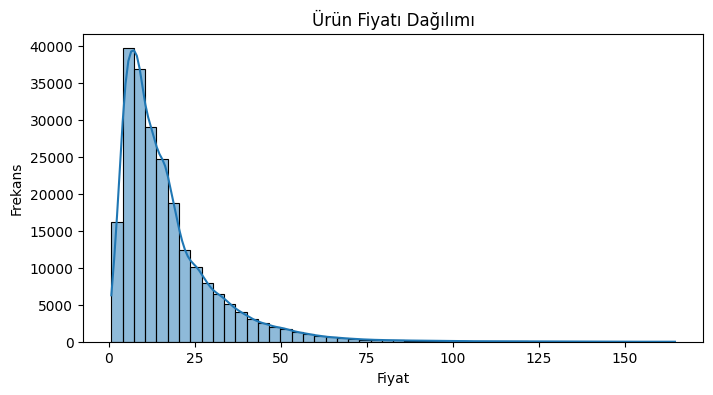

In [8]:
plt.figure(figsize=(8, 4))
sns.histplot(df_train["urun_fiyati"], bins=50, kde=True)
plt.title("Ürün Fiyatı Dağılımı")
plt.xlabel("Fiyat")
plt.ylabel("Frekans")
plt.show()

In [9]:
categorical_cols = df_train.select_dtypes(include="object").columns
for col in categorical_cols:
    print(f"{col}: {df_train[col].nunique()} benzersiz değer")

urun: 79 benzersiz değer
urun_kategorisi: 6 benzersiz değer
urun_uretim_yeri: 2 benzersiz değer
market: 3 benzersiz değer
sehir: 8 benzersiz değer


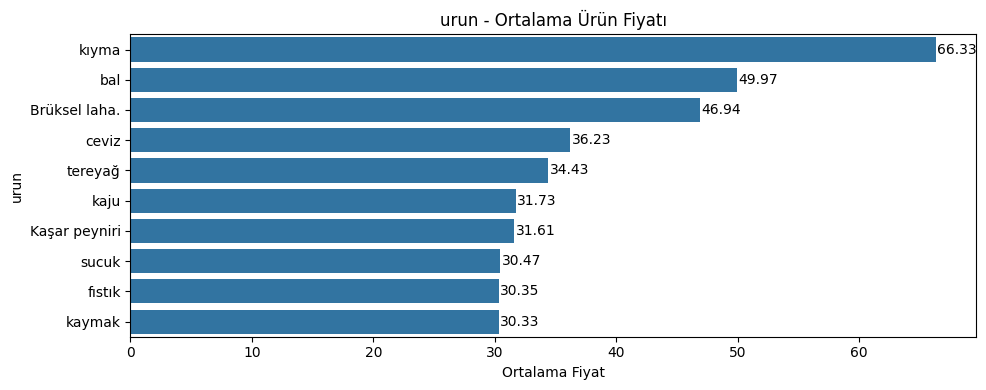

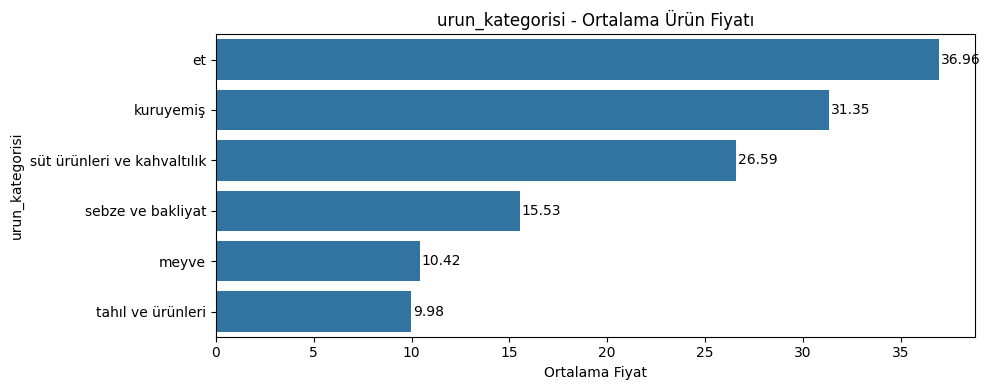

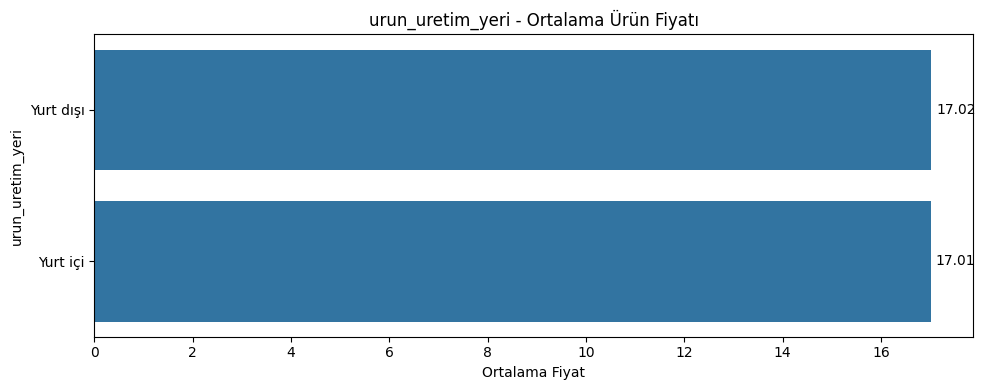

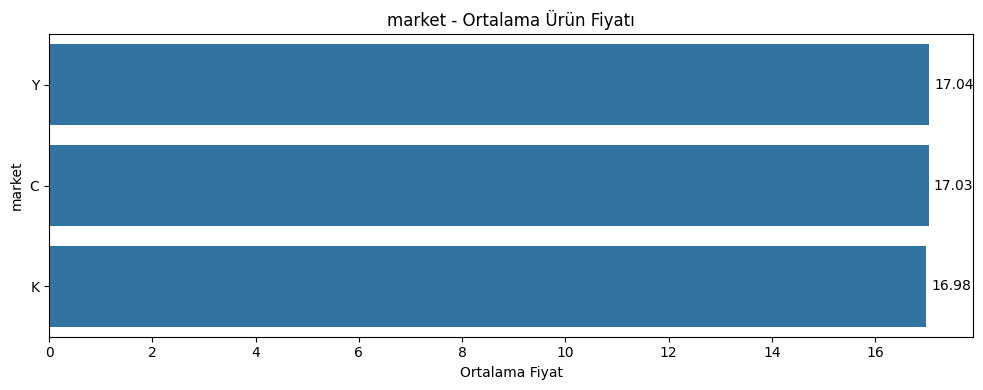

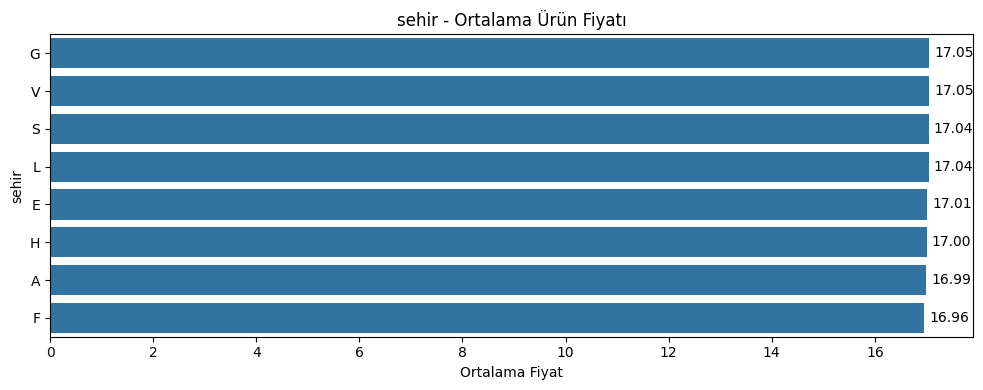

In [10]:

for col in categorical_cols:
    plt.figure(figsize=(10, 4))
    mean_values = df_train.groupby(col)["urun_fiyati"].mean().sort_values(ascending=False).head(10)

    ax = sns.barplot(x=mean_values.values, y=mean_values.index)

    # Rakamları çubukların üzerine yaz
    for i, value in enumerate(mean_values.values):
        ax.text(value + 0.1, i, f"{value:.2f}", va='center')

    plt.title(f"{col} - Ortalama Ürün Fiyatı")
    plt.xlabel("Ortalama Fiyat")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

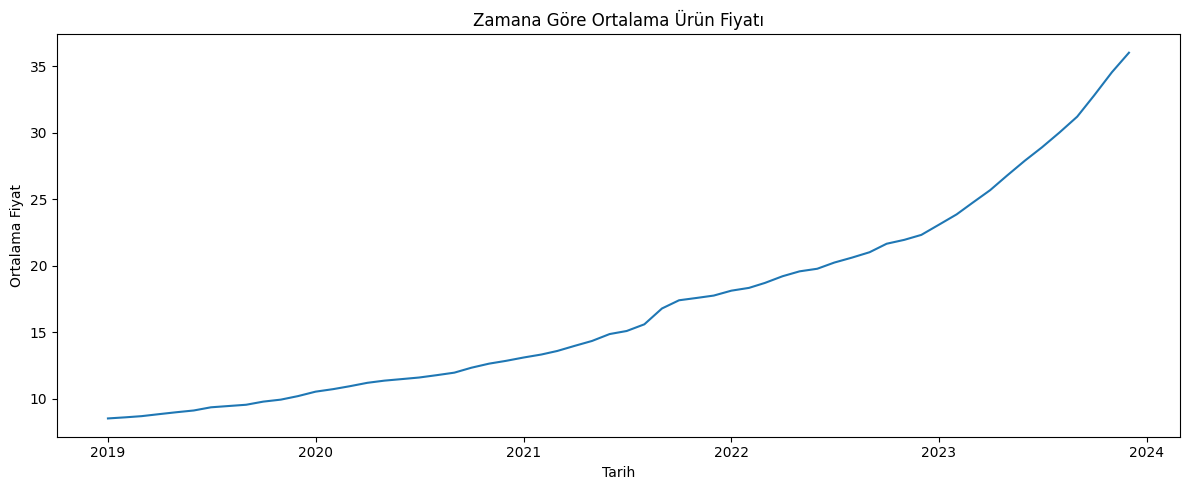

In [11]:
plt.figure(figsize=(12, 5))
df_daily = df_train.groupby("tarih")["urun_fiyati"].mean()
sns.lineplot(x=df_daily.index, y=df_daily.values)
plt.title("Zamana Göre Ortalama Ürün Fiyatı")
plt.xlabel("Tarih")
plt.ylabel("Ortalama Fiyat")
plt.tight_layout()
plt.show()


In [12]:
df_train.groupby("sehir").agg({"urun_fiyati": "mean"})

,urun_fiyati
sehir,
A,16.989788
E,17.009177
F,16.960585
G,17.052943
H,17.002563
L,17.043999
S,17.044352
V,17.047288


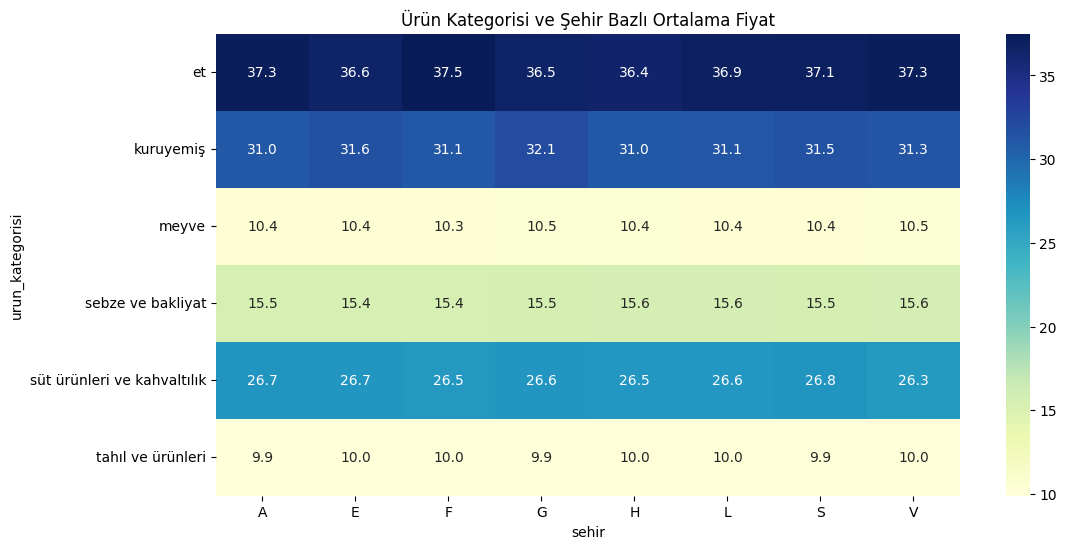

In [13]:
pivot_table = df_train.pivot_table(
    values="urun_fiyati",
    index="urun_kategorisi",
    columns="sehir",
    aggfunc="mean"
)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Ürün Kategorisi ve Şehir Bazlı Ortalama Fiyat")
plt.show()


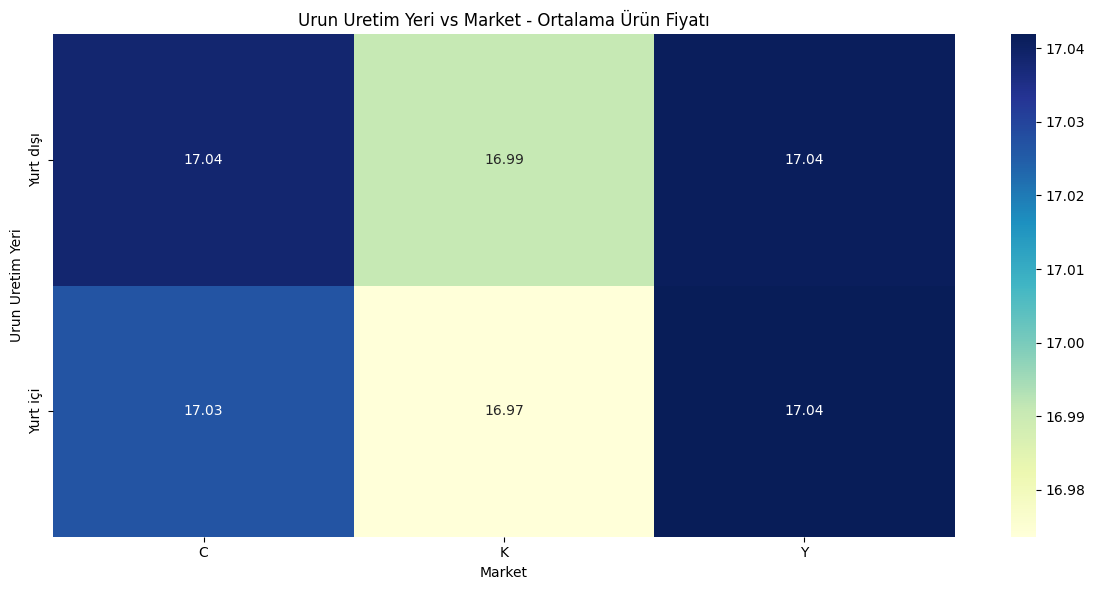

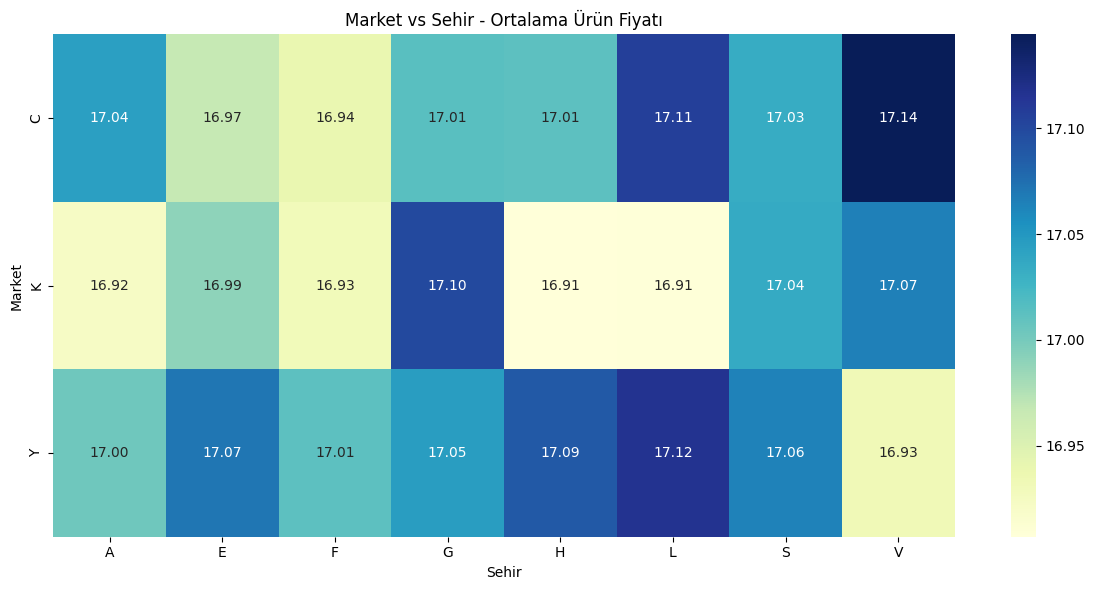

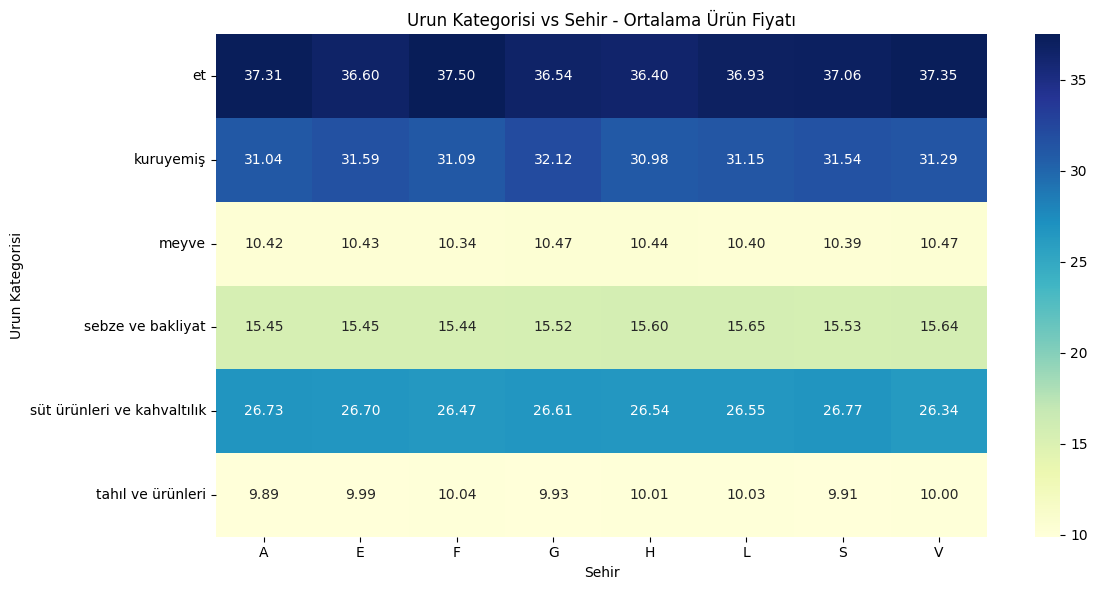

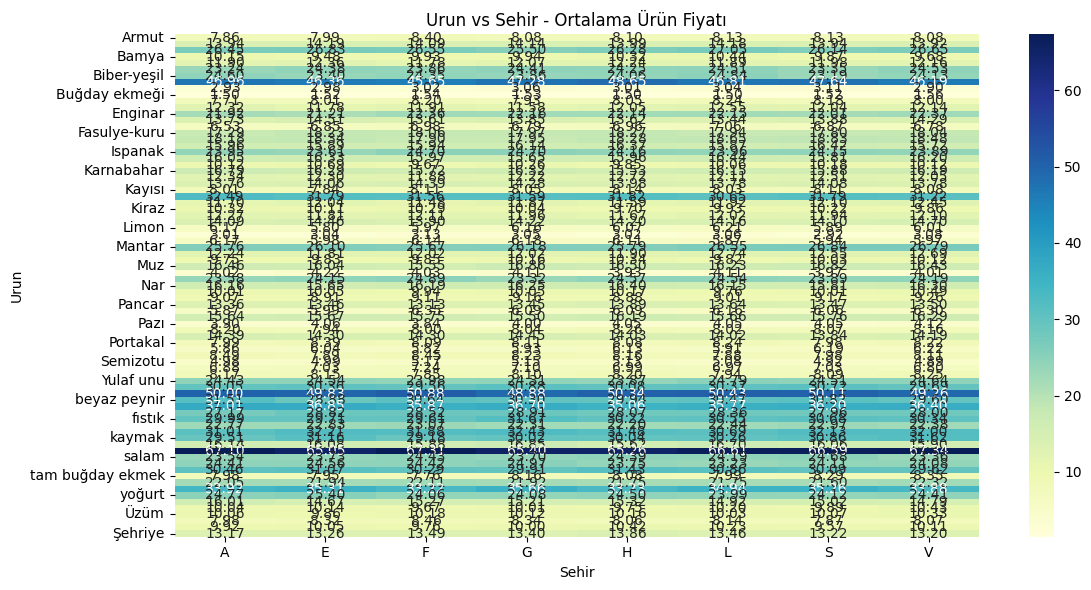

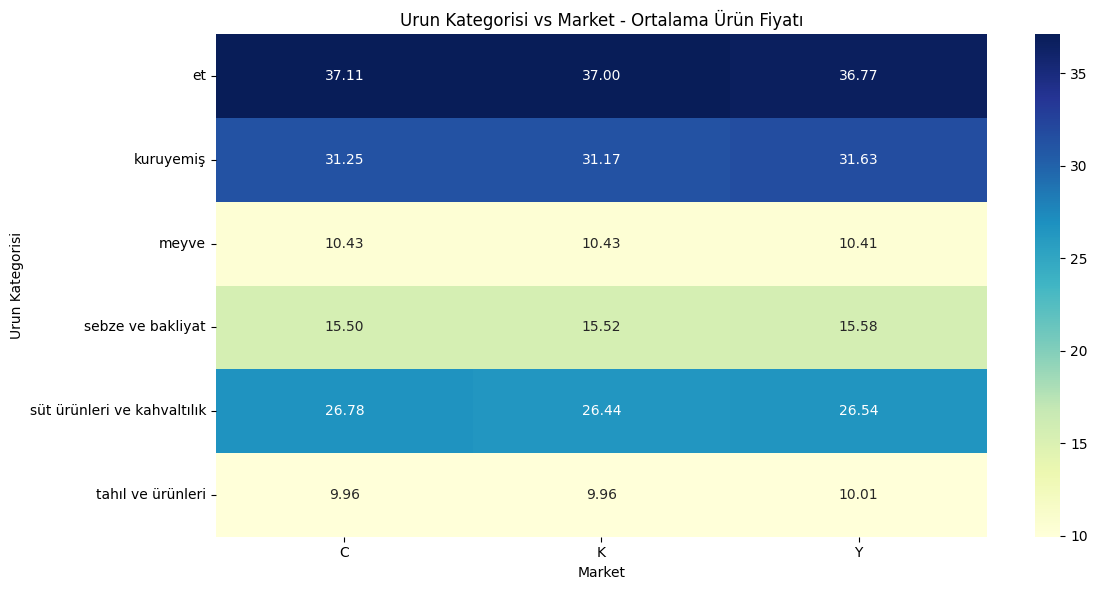

In [14]:
combinations = [
    ("urun_uretim_yeri", "market"),
    ("market", "sehir"),
    ("urun_kategorisi", "sehir"),
    ("urun", "sehir"),
    ("urun_kategorisi", "market"),
]

for row_col in combinations:
    row, col = row_col

    # Pivot tablo oluştur
    pivot_table = df_train.pivot_table(
        values="urun_fiyati",
        index=row,
        columns=col,
        aggfunc="mean"
    )

    # Heatmap çiz
    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", fmt= ".2f")
    plt.title(f"{row.replace('_', ' ').title()} vs {col.replace('_', ' ').title()} - Ortalama Ürün Fiyatı")
    plt.xlabel(col.replace('_', ' ').title())
    plt.ylabel(row.replace('_', ' ').title())
    plt.tight_layout()
    plt.show()


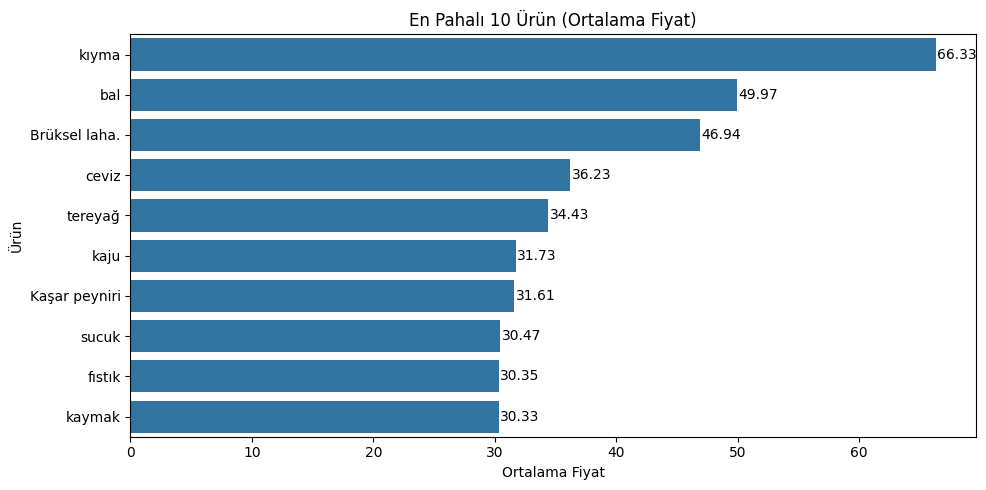

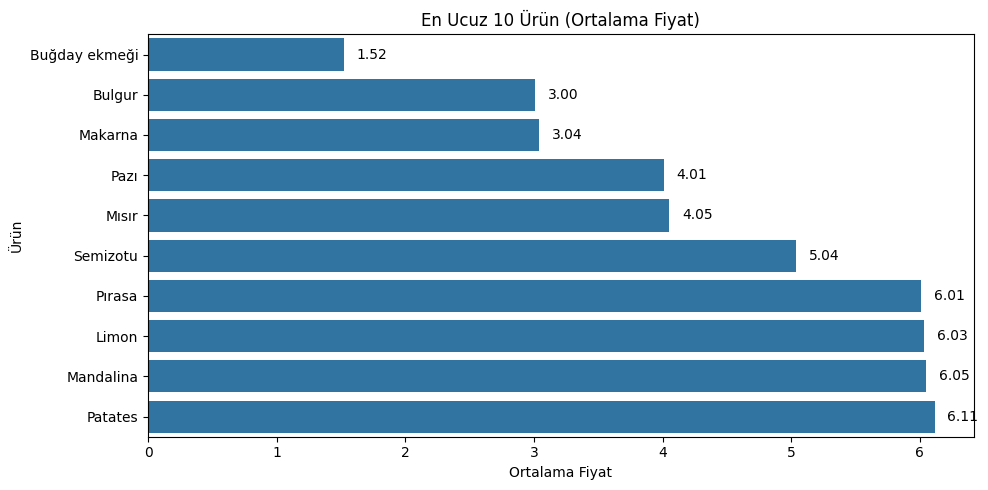

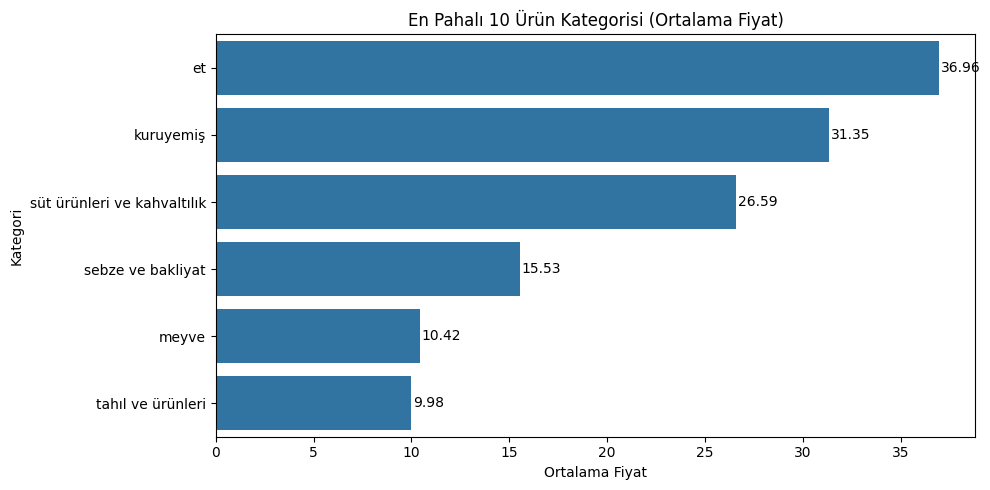

In [15]:
top_expensive_products = df_train.groupby("urun")["urun_fiyati"].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_expensive_products.values, y=top_expensive_products.index)
for index, value in enumerate(top_expensive_products.values):
    plt.text(value + 0.1, index, f"{value:.2f}", va='center')
plt.title("En Pahalı 10 Ürün (Ortalama Fiyat)")
plt.xlabel("Ortalama Fiyat")
plt.ylabel("Ürün")
plt.tight_layout()
plt.show()


top_cheap_products = df_train.groupby("urun")["urun_fiyati"].mean().sort_values().head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_cheap_products.values, y=top_cheap_products.index)
for index, value in enumerate(top_cheap_products.values):
    plt.text(value + 0.1, index, f"{value:.2f}", va='center')
plt.title("En Ucuz 10 Ürün (Ortalama Fiyat)")
plt.xlabel("Ortalama Fiyat")
plt.ylabel("Ürün")
plt.tight_layout()
plt.show()


top_expensive_categories = df_train.groupby("urun_kategorisi")["urun_fiyati"].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_expensive_categories.values, y=top_expensive_categories.index)
for index, value in enumerate(top_expensive_categories.values):
    plt.text(value + 0.1, index, f"{value:.2f}", va='center')
plt.title("En Pahalı 10 Ürün Kategorisi (Ortalama Fiyat)")
plt.xlabel("Ortalama Fiyat")
plt.ylabel("Kategori")
plt.tight_layout()
plt.show()

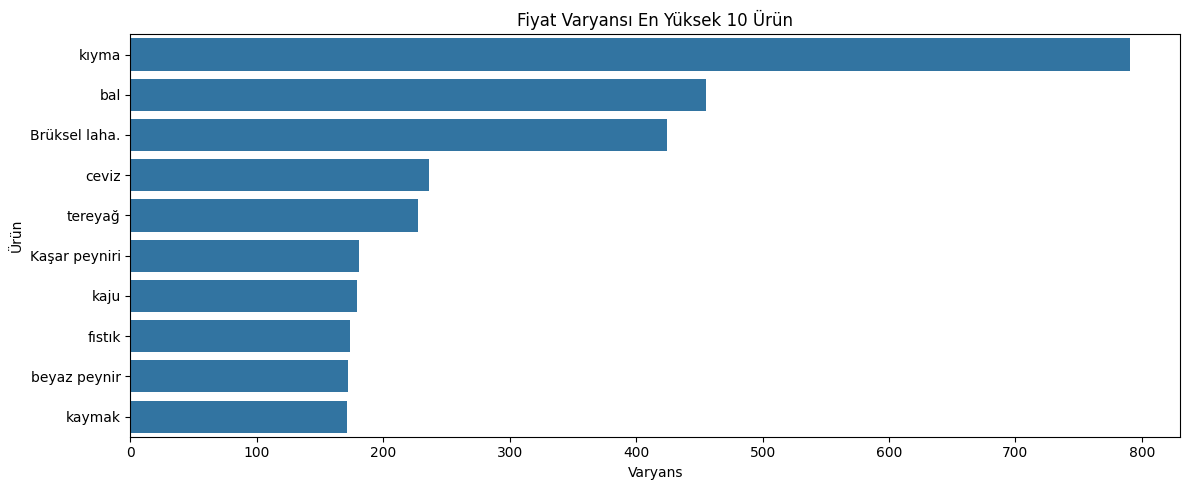

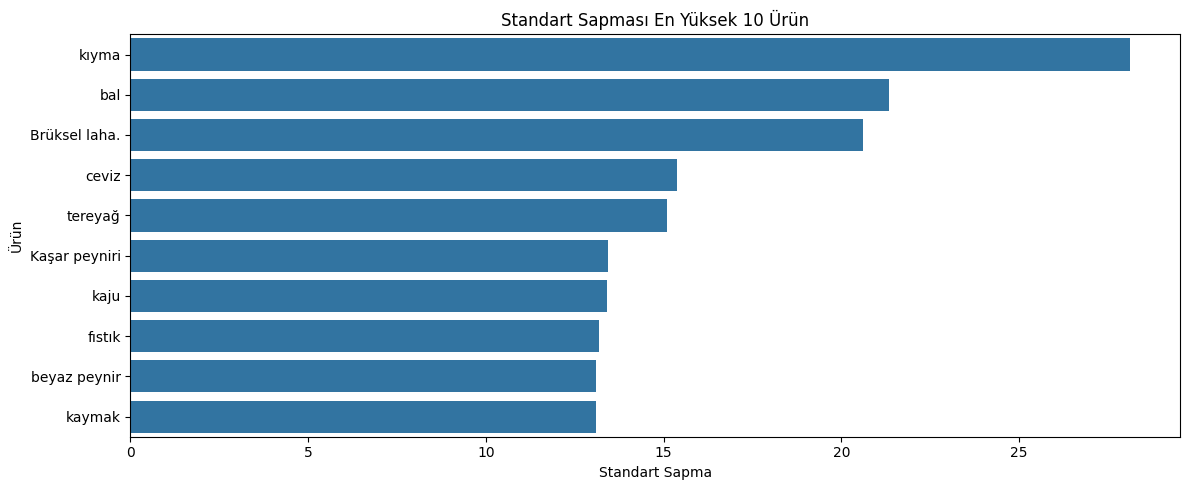

In [16]:

urun_variance = df_train.groupby("urun")["urun_fiyati"].var().sort_values(ascending=False)

plt.figure(figsize=(12, 5))
sns.barplot(x=urun_variance.head(10).values, y=urun_variance.head(10).index)
plt.title("Fiyat Varyansı En Yüksek 10 Ürün")
plt.xlabel("Varyans")
plt.ylabel("Ürün")
plt.tight_layout()
plt.show()

urun_std = df_train.groupby("urun")["urun_fiyati"].std().sort_values(ascending=False)

plt.figure(figsize=(12, 5))
sns.barplot(x=urun_std.head(10).values, y=urun_std.head(10).index)
plt.title("Standart Sapması En Yüksek 10 Ürün")
plt.xlabel("Standart Sapma")
plt.ylabel("Ürün")
plt.tight_layout()
plt.show()

In [17]:
def explained_variance_ratio(df, target_col, group_col):
    overall_mean = df[target_col].mean()
    groups = df.groupby(group_col)[target_col]
    n = df.shape[0]

    between_var = sum(
        len(group) * ((group.mean() - overall_mean) ** 2)
        for _, group in groups
    )
    total_var = df[target_col].var() * n
    return between_var / total_var

# Değerlendirmek istediğimiz kategorik değişkenler
cat_cols = ["urun", "urun_kategorisi", "sehir", "market", "urun_uretim_yeri"]

# Her bir değişkenin açıklama oranını hesaplayalım
for col in cat_cols:
    ratio = explained_variance_ratio(df_train, "urun_fiyati", col)
    print(f"{col} açıklama oranı: {ratio:.3f}")

urun açıklama oranı: 0.628
urun_kategorisi açıklama oranı: 0.288
sehir açıklama oranı: 0.000
market açıklama oranı: 0.000
urun_uretim_yeri açıklama oranı: 0.000


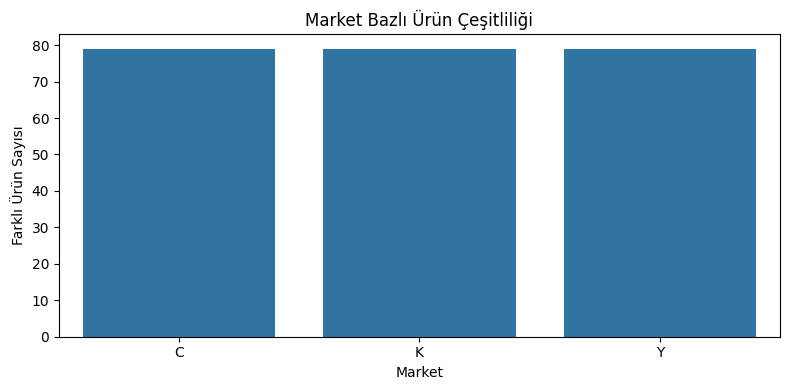

In [18]:
market_urun_sayisi = df_train.groupby("market")["urun"].nunique().sort_values(ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(x=market_urun_sayisi.index, y=market_urun_sayisi.values)
plt.title("Market Bazlı Ürün Çeşitliliği")
plt.xlabel("Market")
plt.ylabel("Farklı Ürün Sayısı")
plt.tight_layout()
plt.show()

# Feature Engineering Kısmı

In [19]:

df_train["source"] = "train"
df_test["source"] = "test"
df_test["urun_fiyati"] = np.nan  


combined_df = pd.concat([df_train, df_test], ignore_index=True)


In [20]:
combined_df["besin_basi_fiyat"] = combined_df["urun_fiyati"] / combined_df["urun_besin_degeri"]
combined_df["besin_basi_fiyat"].replace([np.inf, -np.inf], np.nan, inplace=True)

In [21]:
threshold = combined_df.loc[combined_df["source"] == "train", "besin_basi_fiyat"].quantile(0.90)

combined_df["premium_urun_mu"] = (combined_df["besin_basi_fiyat"] >= threshold).astype(int)


In [22]:

combined_df["kategori_market"] = combined_df["urun_kategorisi"] + "_" + combined_df["market"]
combined_df["urun_sehir"] = combined_df["urun"] + "_" + combined_df["sehir"]
combined_df["uretimyeri_market"] = combined_df["urun_uretim_yeri"] + "_" + combined_df["market"]
combined_df["market_sehir"] = combined_df["market"] + "_" + combined_df["sehir"]
combined_df["sehir_kategori"] = combined_df["sehir"] + "_" + combined_df["urun_kategorisi"]


In [23]:
kategori_map = {
    # Et ürünleri
    "kıyma": "kirmizi_et", "sucuk": "kirmizi_et", "salam": "kirmizi_et", "sosis": "kirmizi_et",
    "tavuk": "beyaz_et", "hindi": "beyaz_et",

    # Bakliyat
    "bakla-kuru": "bakliyat", "barbunya-kuru": "bakliyat", "fasulye-kuru": "bakliyat", 
    "mercimek-kuru": "bakliyat", "nohut": "bakliyat",

    # Sebzeler
    "bamya": "sebze", "bezelye-taze": "sebze", "biber-yeşil": "sebze", "brüksel laha.": "sebze",
    "domates": "sebze", "enginar": "sebze", "fasulye-taze": "sebze", "havuc": "sebze", "salatalık": "sebze",
    "ıspanak": "sebze", "kabak": "sebze", "karnabahar": "sebze", "kereviz-baş": "sebze", 
    "kırmızı-pancar": "sebze", "lahana": "sebze", "mantar": "sebze", "marul": "sebze",
    "pancar": "sebze", "patates": "sebze", "patlıcan": "sebze", "pazı": "sebze", 
    "pırasa": "sebze", "semizotu": "sebze", "kıvırcık": "sebze",

    # Tahıllar ve Ekmek Ürünleri
    "buğday ekmeği": "tahil_ekmek", "tam buğday ekmek": "tahil_ekmek", "bulgur": "tahil_ekmek",
    "erişte": "tahil_ekmek", "makarna": "tahil_ekmek", "mısır": "tahil_ekmek", "mısır unu": "tahil_ekmek",
    "nişasta": "tahil_ekmek", "pilav": "tahil_ekmek", "pirinç unu": "tahil_ekmek", "şehriye": "tahil_ekmek",
    "tarhana": "tahil_ekmek", "yulaf unu": "tahil_ekmek",

    # Süt ve Süt Ürünleri
    "yoğurt": "sut_urunu", "beyaz peynir": "sut_urunu", "kaşar peyniri": "sut_urunu",
    "krema": "sut_urunu", "kaymak": "sut_urunu", "tereyağ": "sut_urunu", "yumurta": "sut_urunu",

    # Tatlı
    "bal": "tatli",

    # Meyveler
    "armut": "meyve", "çilek": "meyve", "elma": "meyve", "erik türleri": "meyve", 
    "incir": "meyve", "karadut": "meyve", "karpuz": "meyve", "kavun": "meyve",
    "kayısı": "meyve", "kiraz": "meyve", "limon": "meyve", "mandalina": "meyve",
    "muz": "meyve", "nar": "meyve", "portakal": "meyve", "şeftali": "meyve", 
    "üzüm": "meyve", "vişne": "meyve",

    # Kuruyemiş
    "fındık": "kuruyemis", "fıstık": "kuruyemis", "kaju": "kuruyemis", 
    "badem": "kuruyemis", "ceviz": "kuruyemis",

    
}

koken_map = {
    "kirmizi_et": "hayvansal",
    "beyaz_et": "hayvansal",
    "sut_urunu": "hayvansal",
    "yumurta": "hayvansal",
    "bakliyat": "bitkisel",
    "sebze": "bitkisel",
    "meyve": "bitkisel",
    "tahil_ekmek": "bitkisel",
    "kuruyemis": "bitkisel",
    "tatli": "bitkisel"
}



# Ürünleri küçük harfe çevir ve eşleştir
combined_df["urun_lower"] = combined_df["urun"].str.lower().str.strip()

# Kategori ve köken eşle
combined_df["yeni_urun_kategorisi"] = combined_df["urun_lower"].map(kategori_map)
combined_df["besin_kokeni"] = combined_df["yeni_urun_kategorisi"].map(koken_map)

# Eksikleri "diger" olarak doldur
combined_df["yeni_urun_kategorisi"].fillna("diger", inplace=True)
combined_df["besin_kokeni"].fillna("diger", inplace=True)



In [24]:
# Train verisinden gruplara göre ortalama besin başı fiyat hesapla
mean_bbf = combined_df[combined_df["source"] == "train"].groupby("urun_lower")["besin_basi_fiyat"].mean()

# Test setindeki NaN olanları bu ortalama ile doldur
combined_df["besin_basi_fiyat"] = combined_df.apply(
    lambda row: mean_bbf[row["urun_lower"]] if pd.isna(row["besin_basi_fiyat"]) else row["besin_basi_fiyat"],
    axis=1
)


In [25]:
# Sadece train seti baz alınarak %90'lık eşik belirlenir
premium_threshold = combined_df.loc[combined_df["source"] == "train", "besin_basi_fiyat"].quantile(0.90)

# Yeni kolon: premium ürün mü?
combined_df["premium_urun_mu"] = (combined_df["besin_basi_fiyat"] >= premium_threshold).astype(int)


In [26]:
# tarih kolonunu datetime formatına çevir
combined_df["tarih"] = pd.to_datetime(combined_df["tarih"], errors="coerce")

# Yeni zaman temelli kolonlar
combined_df["yil"] = combined_df["tarih"].dt.year
combined_df["ay"] = combined_df["tarih"].dt.month
combined_df["gun"] = combined_df["tarih"].dt.day
combined_df["hafta_gunu"] = combined_df["tarih"].dt.dayofweek  # 0 = Pazartesi
combined_df["hafta"] = combined_df["tarih"].dt.isocalendar().week
combined_df["ay_basligi"] = combined_df["tarih"].dt.strftime('%B')

# Mevsim belirleme fonksiyonu
def mevsim_belirle(ay):
    if ay in [12, 1, 2]:
        return "kış"
    elif ay in [3, 4, 5]:
        return "ilkbahar"
    elif ay in [6, 7, 8]:
        return "yaz"
    else:
        return "sonbahar"

# Mevsim kolonu
combined_df["mevsim"] = combined_df["ay"].apply(mevsim_belirle)


In [27]:
# 1. kategori_market
combined_df["kategori_market"] = combined_df["yeni_urun_kategorisi"] + "_" + combined_df["market"]

# 2. urun_sehir
combined_df["urun_sehir"] = combined_df["urun_lower"] + "_" + combined_df["sehir"]

# 3. urunuretimyeri_market
combined_df["urunuretimyeri_market"] = combined_df["urun_uretim_yeri"] + "_" + combined_df["market"]

# 4. market_sehir
combined_df["market_sehir"] = combined_df["market"] + "_" + combined_df["sehir"]

# 5. sehir_kategori
combined_df["sehir_kategori"] = combined_df["sehir"] + "_" + combined_df["yeni_urun_kategorisi"]


# 1. kategori_market → kaç kere geçmiş
kategori_market_freq = combined_df["kategori_market"].value_counts().to_dict()
combined_df["kategori_market_freq"] = combined_df["kategori_market"].map(kategori_market_freq)

# 2. urun_sehir → kaç kere geçmiş
urun_sehir_freq = combined_df["urun_sehir"].value_counts().to_dict()
combined_df["urun_sehir_freq"] = combined_df["urun_sehir"].map(urun_sehir_freq)

# 3. urunuretimyeri_market → kaç kere geçmiş
urunuretimyeri_market_freq = combined_df["urunuretimyeri_market"].value_counts().to_dict()
combined_df["urunuretimyeri_market_freq"] = combined_df["urunuretimyeri_market"].map(urunuretimyeri_market_freq)

# 4. market_sehir → kaç kere geçmiş
market_sehir_freq = combined_df["market_sehir"].value_counts().to_dict()
combined_df["market_sehir_freq"] = combined_df["market_sehir"].map(market_sehir_freq)

# 5. sehir_kategori → kaç kere geçmiş
sehir_kategori_freq = combined_df["sehir_kategori"].value_counts().to_dict()
combined_df["sehir_kategori_freq"] = combined_df["sehir_kategori"].map(sehir_kategori_freq)


In [28]:

# --- 1. Döviz Verisi (Günlük) ---
kur_df = pd.read_csv("datasets/GunlukKur.csv", encoding="utf-8")
kur_df = kur_df.rename(columns={
    "Tarih": "tarih",
    "TP DK USD A YTL": "usd_satis_kuru"
})
kur_df["tarih"] = pd.to_datetime(kur_df["tarih"], format="%d-%m-%Y", errors="coerce")
kur_df["usd_satis_kuru"] = pd.to_numeric(kur_df["usd_satis_kuru"], errors="coerce")
# Aynı tarihli verileri ortalama alarak birleştir
kur_df = (
    kur_df.groupby("tarih", as_index=False)
    .agg({"usd_satis_kuru": "mean"})
    .sort_values("tarih")
)

# Eksik günleri tamamlama + ileriye doğru doldurma
kur_df = kur_df.set_index("tarih").asfreq("D")
kur_df["usd_satis_kuru"] = kur_df["usd_satis_kuru"].ffill()
kur_df.reset_index(inplace=True)

# Aylık periyod kolonu
kur_df["yil_ay"] = kur_df["tarih"].dt.to_period("M")

kur_df.loc[kur_df["tarih"] == pd.Timestamp("2019-01-01"), "usd_satis_kuru"] = 5.28
# --- 2. TÜFE Genel (Aylık) ---
tufe_df = pd.read_csv("datasets/TuketiciFiyatEndeksi.csv", encoding="utf-8")
tufe_df = tufe_df.rename(columns={
    "Tarih": "tarih",
    "TuketiciFiyatEndeksi": "tufe"
})
tufe_df["tarih"] = pd.to_datetime(tufe_df["tarih"], format="%d/%m/%Y", errors="coerce")
tufe_df = tufe_df[["tarih", "tufe"]].sort_values("tarih")
tufe_df["yil_ay"] = tufe_df["tarih"].dt.to_period("M")

# --- 3. TÜFE Gıda (Aylık) ---
tufe_gida_df = pd.read_csv("datasets/AylikTUIKFiyatEndeksi.csv", encoding="utf-8")
tufe_gida_df = tufe_gida_df.rename(columns={
    "Tarih": "tarih",
    "TP FG J011": "tufe_gida"
})
tufe_gida_df["tarih"] = pd.to_datetime(tufe_gida_df["tarih"], format="%Y-%m", errors="coerce")
tufe_gida_df = tufe_gida_df[["tarih", "tufe_gida"]].sort_values("tarih")
tufe_gida_df["yil_ay"] = tufe_gida_df["tarih"].dt.to_period("M")

# --- 4. combined_df Üzerinde yil_ay kolonu oluştur ---
combined_df["yil_ay"] = combined_df["tarih"].dt.to_period("M")

# --- 5. Birleştirme İşlemleri ---
combined_df = combined_df.merge(kur_df[["tarih", "usd_satis_kuru"]], on="tarih", how="left")
combined_df = combined_df.merge(tufe_df[["yil_ay", "tufe"]], on="yil_ay", how="left")
combined_df = combined_df.merge(tufe_gida_df[["yil_ay", "tufe_gida"]], on="yil_ay", how="left")

# Feature Engineering Kontrol

İlk denememiz ardından eklenen bazı featureların model içerisinde overfitting veya leakage problemine sebebiyet verebileceğini düşündüğümüzden çıkarımlarını gerçekleştirdik.

In [29]:
columns_to_keep = ["source", "id"]

freq_cols = [col for col in combined_df.columns if "freq" in col]

explicit_drops = ["tarih", "besin_basi_fiyat", "premium_urun_mu"]

columns_to_drop = freq_cols + explicit_drops

columns_to_drop = [col for col in columns_to_drop if col in combined_df.columns]

clean_df_v1 = combined_df.drop(columns=columns_to_drop)



In [31]:
df_feat_v1 = clean_df_v1.copy()

urun_mean = df_feat_v1.groupby("urun")["urun_fiyati"].mean().rename("urun_ortalama_fiyati")
df_feat = df_feat_v1.merge(urun_mean, on="urun", how="left")

urun_time_mean = df_feat_v1.groupby(["urun", "yil", "ay"])["urun_fiyati"].mean().rename("urun_yil_ay_ortalama_fiyat")
df_feat_v1 = df_feat_v1.merge(urun_time_mean, on=["urun", "yil", "ay"], how="left")

urun_kat_stats = df_feat_v1.groupby("urun_kategorisi")["urun_fiyati"].agg(["std", "mean"]).reset_index()
urun_kat_stats["urun_kategori_cv"] = urun_kat_stats["std"] / urun_kat_stats["mean"]
urun_kat_stats = urun_kat_stats.rename(columns={
    "std": "urun_kategori_std_fiyat",
    "mean": "urun_kategori_mean_fiyat"
})
df_feat_v1 = df_feat_v1.merge(urun_kat_stats[["urun_kategorisi", "urun_kategori_std_fiyat", "urun_kategori_cv"]], on="urun_kategorisi", how="left")

df_feat_v1["fiyat_tufe_orani"] = df_feat_v1["urun_fiyati"] / df_feat_v1["tufe"]
df_feat_v1["fiyat_usd_orani"] = df_feat_v1["urun_fiyati"] / df_feat_v1["usd_satis_kuru"]


In [32]:
drop_features = [
    "urun_yil_ay_ortalama_fiyat",
    "fiyat_tufe_orani",
    "fiyat_usd_orani",
    "urun_ortalama_fiyati"
]

drop_features = [col for col in drop_features if col in df_feat_v1.columns]
df_feat_v1 = df_feat_v1.drop(columns=drop_features)

# Encoding

In [33]:
encoded_df_v1 = df_feat_v1.copy()

one_hot_cols = [
    "urun_kategorisi", 
    "urun_uretim_yeri", 
    "mevsim", 
    "besin_kokeni"
]

label_cols = [
    "urun", "market", "sehir", "yeni_urun_kategorisi",
    "kategori_market", "urun_sehir", "uretimyeri_market",
    "market_sehir", "sehir_kategori", "urunuretimyeri_market"
]

drop_cols = ["source", "id", "urun_lower", "gun", "hafta_gunu", "hafta", "ay_basligi", "yil_ay"]
drop_cols = [col for col in drop_cols if col in encoded_df_v1.columns]
encoded_df_v1.drop(columns=drop_cols, inplace=True)

encoded_df_v1 = pd.get_dummies(encoded_df_v1, columns=one_hot_cols, drop_first=True)

le = LabelEncoder()
for col in label_cols:
    if col in encoded_df_v1.columns:
        encoded_df_v1[col] = le.fit_transform(encoded_df_v1[col])

# Modelleme:

İlk denememizde XGBoost kullanmıştık. Sonrasında 4 yeni model deneyip bunların en düşük RMSE değerine sahip olanını seçmeye karar verdik.

In [34]:
df_train_final_v1 = encoded_df_v1[df_feat_v1["source"] == "train"].copy()
df_test_final_v1 = encoded_df_v1[df_feat_v1["source"] == "test"].copy()

y_train_v1 = df_train_final_v1["urun_fiyati"]
X_train_v1 = df_train_final_v1.drop(columns=["urun_fiyati"])
X_test_v1 = df_test_final_v1.drop(columns=["urun_fiyati"])

test_ids_v1 = df_feat_v1[df_feat_v1["source"] == "test"]["id"].reset_index(drop=True)

In [35]:
def clean_number(x):
    x = str(x)
    if "," in x and "." in x:
        # Örn: 3,909.87 → 3909.87
        return float(x.replace(",", ""))
    elif "," in x:
        # Örn: 3909,87 → 3909.87
        return float(x.replace(",", "."))
    else:
        return float(x)

for col in X_train_v1.columns:
    if X_train_v1[col].dtype == "object":
        X_train_v1[col] = X_train_v1[col].apply(clean_number)

for col in X_test_v1.columns:
    if X_test_v1[col].dtype == "object":
        X_test_v1[col] = X_test_v1[col].apply(clean_number)

In [37]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_v1, y_train_v1, test_size=0.2, random_state=42
)

models = {
    "XGBoost": XGBRegressor(random_state=42, n_jobs=-1),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42),
    "LightGBM": LGBMRegressor(random_state=42, n_jobs=-1),
    "RandomForest": RandomForestRegressor(random_state=42, n_jobs=-1)
}

results = {}

for name, model in models.items():
    model.fit(X_train_split, y_train_split)
    preds = model.predict(X_val_split)
    rmse = np.sqrt(mean_squared_error(y_val_split, preds))  # düzeltme burada
    results[name] = rmse

sorted_results = dict(sorted(results.items(), key=lambda x: x[1]))
for name, score in sorted_results.items():
    print(f"{name}: RMSE = {score:.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 793
[LightGBM] [Info] Number of data points in the train set: 182016, number of used features: 29
[LightGBM] [Info] Start training from score 17.023668
CatBoost: RMSE = 1.1181
XGBoost: RMSE = 1.1528
RandomForest: RMSE = 1.2272
LightGBM: RMSE = 1.4496


Bu sonuçlarının ardından CatBoost modeli ile devam etmeye karar verdik.

In [ ]:
final_model = CatBoostRegressor(
    depth=7,
    iterations=900,
    l2_leaf_reg=1,
    learning_rate=0.1,
    random_state=42,
    verbose=100
)

final_model.fit(X_train_split, y_train_split)
y_pred = final_model.predict(X_val_split)

rmse = np.sqrt(mean_squared_error(y_val_split, y_pred))
print(f"Validation RMSE (tuned CatBoost): {rmse:.4f}")

0:	learn: 13.4282375	total: 22.6ms	remaining: 20.3s
100:	learn: 1.7597115	total: 1.66s	remaining: 13.1s
200:	learn: 1.3959491	total: 3.24s	remaining: 11.3s
300:	learn: 1.2691687	total: 4.82s	remaining: 9.59s
400:	learn: 1.1702218	total: 6.48s	remaining: 8.06s
500:	learn: 1.1031654	total: 8.28s	remaining: 6.59s
600:	learn: 1.0508988	total: 10s	remaining: 4.99s
700:	learn: 1.0044597	total: 11.7s	remaining: 3.31s
800:	learn: 0.9661906	total: 13.3s	remaining: 1.65s
899:	learn: 0.9296564	total: 14.9s	remaining: 0us
Validation RMSE (tuned CatBoost): 0.9700


Son olarakta aşağıdaki gibi değerleri tahmin edip, CSV dosyasının çıktısını aldık.

In [39]:
final_model = CatBoostRegressor(
    depth=7,
    iterations=900,
    l2_leaf_reg=1,
    learning_rate=0.1,
    random_state=42,
    verbose=100
)

# Tüm train ile eğit
final_model.fit(X_train_v1, y_train_v1)

# Tahmin yap
y_test_pred = final_model.predict(X_test_v1)

# Tahminleri DataFrame'e yaz
submission_df = pd.DataFrame({
    "id": test_ids_v1.astype(int),  # Noktasız ID
    "ürün fiyatı": y_test_pred  # 2 ondalık basamak
})

# CSV'ye kaydet
submission_df.to_csv("submissionCAT_v1.csv", index=False, encoding="utf-8-sig")

0:	learn: 13.4170494	total: 20.7ms	remaining: 18.6s
100:	learn: 1.7700465	total: 1.92s	remaining: 15.2s
200:	learn: 1.3946192	total: 3.92s	remaining: 13.6s
300:	learn: 1.2698331	total: 5.94s	remaining: 11.8s
400:	learn: 1.1904604	total: 8.13s	remaining: 10.1s
500:	learn: 1.1227229	total: 10.4s	remaining: 8.26s
600:	learn: 1.0689707	total: 12.5s	remaining: 6.2s
700:	learn: 1.0248608	total: 14.5s	remaining: 4.13s
800:	learn: 0.9846414	total: 16.5s	remaining: 2.04s
899:	learn: 0.9512693	total: 18.5s	remaining: 0us


Süreç içerisinde
- XGBoost
- Ensemble (CatBoost ve XGBoost)
- CatBoost 
modelleri ile submission yapıldı. En düşük skoru veren CatBoost işlemi notebook içerisinde anlatıldı.